In [1]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
load_dotenv()

True

In [2]:
from langchain_openai import OpenAIEmbeddings
embedding_model=OpenAIEmbeddings(model='text-embedding-3-small')
llm=init_chat_model('openai:gpt-4o-mini')

In [3]:
import bs4
from langchain import hub 
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing_extensions import List,TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
loader=WebBaseLoader(
    web_path=('https://lilianweng.github.io/posts/2023-06-23-agent/'),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=('post-content','post-title','post-header')
        )
    ),
)
docs=loader.load()

In [5]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=200)
all_splits=text_splitter.split_documents(docs)
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Planning\n\nSubgoal and decomposition: The agent breaks down large tasks into sma

In [8]:
from langchain.vectorstores import FAISS
vector_store=FAISS.from_documents(
    documents=all_splits,embedding=embedding_model
)
retriever=vector_store.as_retriever()

In [7]:
from langchain.agents import tool

In [9]:
@tool
def retrieve(query:str):
    """Retrieve the information related to the query"""
    retrieved_docs=retriever.invoke(query)
    serialized="\n\n".join(
        (f"source: {doc.metadata}\n Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized,retrieved_docs

In [10]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END,MessagesState,StateGraph
from langgraph.prebuilt import ToolNode,tools_condition

In [11]:
def query_or_respond(state:MessagesState):
    llm_with_tools=llm.bind_tools([retrieve])
    response=llm_with_tools.invoke(state['messages'])
    return {'messages':[response]}

In [12]:
tools=ToolNode([retrieve])
tools

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'retrieve': StructuredTool(name='retrieve', description='Retrieve the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x7fdc64245080>)}, tool_to_state_args={'retrieve': {}}, tool_to_store_arg={'retrieve': None}, handle_tool_errors=True, messages_key='messages')

In [13]:
def generate(state:MessagesState):
    recent_tool_message=[]
    for message in reversed(state['messages']):
        if message.type=='tool':
            recent_tool_message.append(message)
        else:
            break
    tool_message=recent_tool_message[::-1]

    docs_content="\n\n".join(doc.content for doc in tool_message)
    system_message_content=(
        "You are an assistant for question-answering tasks."
        "use the following pieces of retrieved context to answer"
        "the question.If you dont know the answer,say that you"
        "dont know.use three sentences maximum and keep the answer concise"
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages=[
        message
        for message in state["messages"]
        if message.type in ("human","system")
        or (message.type=='ai' and not message.tool_calls)
    ]
    prompt=[SystemMessage(system_message_content)]+conversation_messages

    response=llm.invoke(prompt)
    return {'messages':[response]}

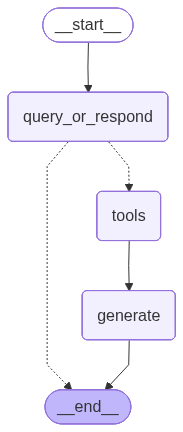

In [14]:
graph_builder=StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    'query_or_respond',
    tools_condition,
    {END:END,'tools':'tools'}
)
graph_builder.add_edge('tools','generate')
graph_builder.add_edge('generate',END)

memory=MemorySaver()
graph=graph_builder.compile(checkpointer=memory)
graph

In [15]:
config={'configurable':{'thread_id':'abc123'}}

In [16]:
input_message="hello"
for step in graph.stream({'messages':[{'role':'user','content':input_message}]},stream_mode='values',config=config):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [17]:
input_message="What is task decomposition"
for step in graph.stream({'messages':[{'role':'user','content':input_message}]},stream_mode='values',config=config):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

What is task decomposition
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_gBecdZq4EsiTWDaFEAsuUVeq)
 Call ID: call_gBecdZq4EsiTWDaFEAsuUVeq
  Args:
    query: task decomposition
================================= Tool Message =================================
Name: retrieve

('source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\n Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\n\nsource: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\n Content: Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decompos

In [18]:
input_message="can you look up some common ways of doing it?"
for step in graph.stream({'messages':[{'role':'user','content':input_message}]},stream_mode='values',config=config):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_OWad3HoiXii9xJtcG1ie7jNP)
 Call ID: call_OWad3HoiXii9xJtcG1ie7jNP
  Args:
    query: common methods for task decomposition
================================= Tool Message =================================
Name: retrieve

('source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\n Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\n\nsource: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\n Content: Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what t

##### conversation history

In [19]:
chat_history=graph.get_state(config).values['messages']
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

What is task decomposition
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_gBecdZq4EsiTWDaFEAsuUVeq)
 Call ID: call_gBecdZq4EsiTWDaFEAsuUVeq
  Args:
    query: task decomposition
================================= Tool Message =================================
Name: retrieve

('source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\n Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\n\nsource: {\'source\': \'htt

#### ReAct Agent Architecture-Persistent Memory

In [20]:
from langgraph.prebuilt import create_react_agent
memory=MemorySaver()
agent_executor=create_react_agent(llm,[retrieve],checkpointer=memory)

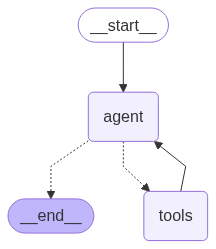

In [21]:
agent_executor

In [33]:
config={'configurable':{'thread_id':'def234'}}

In [34]:
input_message=(
    "what is the standard method for task decomposition?\n\n"
    "once you get the answer,look up common extensions of that method"
)

In [35]:
for event in agent_executor.stream({"messages":[{"role":"user","content":input_message}]},
                                   stream_mode='values',config=config):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what is the standard method for task decomposition?

once you get the answer,look up common extensions of that method
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_g197X7Zi8pItq9yVmCzpP6Yd)
 Call ID: call_g197X7Zi8pItq9yVmCzpP6Yd
  Args:
    query: standard method for task decomposition
  retrieve (call_BYGP9fHX75VNCCzKYNCRVQhV)
 Call ID: call_BYGP9fHX75VNCCzKYNCRVQhV
  Args:
    query: common extensions of task decomposition methods
================================= Tool Message =================================
Name: retrieve

('source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\n Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel,